In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [2]:
import fsps
import sedpy
import prospect

In [3]:
import emcee
import dynesty

In [30]:
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt

In [13]:
obs = {}

# These are the names of the relevant filters, 
# in the same order as the photometric data (see below)
jwst = ['jwst_{0}'.format(b) for b in ['f115w','f150w','f182m','f200w','f210m',
                                       'f277w', 'f335m', 'f356w', 'f410m', 'f430m',
                                       'f444w', 'f460m', 'f480m']]
#["F090W", "F115W", "F150W","F182M", "F200W","F210M",
 #           "F277W", "F335M", "F356W", "F410M","F430M", "F444W",
 #           "F460M", "F480M"]
filternames = jwst
# And here we instantiate the `Filter()` objects using methods in `sedpy`,
# and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
obs["filters"] = sedpy.observate.load_filters(filternames)


In [18]:
photometrytable = fits.open("/home/cal/fabg/ObservationalAnalytic/FinalWSally/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits")

In [21]:
filters = ["F090W", "F115W", "F150W","F182M", "F200W","F210M", 
               "F277W", "F335M", "F356W", "F410M","F430M", "F444W", 
              "F460M", "F480M"]

# GET THEIR WAVELENGTH PIVOT 
# micron
wave_pivot_obs = []
for fil in filters:
    pivot = photometry[1].data["WAVE_PIVOT"][photometry[1].data["NAME"] == fil][0]
    wave_pivot_obs.append(pivot)
    
# GET THE PHOTOMETRY VALUE FOR EACH FILTER 
# Flux of source within circular aperture of 80% enclosed energy radius
# nJy
photometry_data = []
for fil in filters: 
    #c_ap[0] circ0 - 80%
    photometry_data.append(photometry[4].data[fil+"_"+"CIRC0"][32675])

Text(0, 0.5, 'Flux (nJy)')

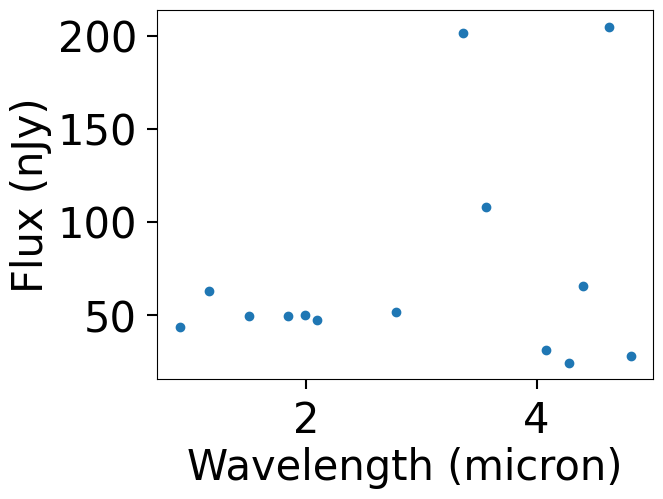

In [24]:
plt.scatter(wave_pivot_obs, photometry_data)
plt.xlabel("Wavelength (micron)")
plt.ylabel("Flux (nJy)")

In [25]:
np.array(['spitzer' not in f.name for f in obs["filters"]])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [26]:
np.array([f.wave_effective for f in obs["filters"]])

array([11485.92019252, 14944.2228431 , 18423.62025761, 19781.13829066,
       20937.46936818, 27612.08682983, 33587.61049854, 35483.48444191,
       40793.28167745, 42801.767424  , 43787.83073433, 46285.07362642,
       48148.54837531])

In [37]:
# The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
m_AB = -2.5 * np.log10((photometry_data * u.nJy).to(u.Jansky)/(3631*u.Jansky))
obs["maggies"] = 10**(-0.4*m_AB).value

# And now we store the uncertainties (again in units of maggies)
# In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
obs["maggies_unc"] = (1./10.0) * obs["maggies"]

In [51]:
from prospect.utils.obsutils import fix_obs
import sedpy

# The obs dictionary, empty for now
obs = {}

# These are the names of the relevant filters, 
# in the same order as the photometric data (see below)
jwst = ['jwst_{0}'.format(b) for b in ['f115w','f150w','f182m','f200w','f210m',
                                    'f277w', 'f335m', 'f356w', 'f410m', 'f430m',
                                    'f444w', 'f460m', 'f480m']]
filternames = jwst
# And here we instantiate the `Filter()` objects using methods in `sedpy`,
# and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
obs["filters"] = sedpy.observate.load_filters(filternames)

# Now we store the measured fluxes for a single object, **in the same order as "filters"**
# In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
# We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
# You could also, e.g. read from a catalog.
# The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
m_AB = -2.5 * np.log10((photometry_data * u.nJy).to(u.Jansky)/(3631*u.Jansky))
obs["maggies"] = 10**(-0.4*m_AB)

# And now we store the uncertainties (again in units of maggies)
# In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
obs["maggies_unc"] = (1./10.0) * obs["maggies"]

# Now we need a mask, which says which flux values to consider in the likelihood.
# IMPORTANT: the mask is *True* for values that you *want* to fit, 
# and *False* for values you want to ignore.  Here we ignore the spitzer bands.
obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])

# This is an array of effective wavelengths for each of the filters.  
# It is not necessary, but it can be useful for plotting so we store it here as a convenience
obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

# We do not have a spectrum, so we set some required elements of the obs dictionary to None.
# (this would be a vector of vacuum wavelengths in angstroms)
obs["wavelength"] = None
# (this would be the spectrum in units of maggies)
obs["spectrum"] = None
# (spectral uncertainties are given here)
obs['unc'] = None
# (again, to ignore a particular wavelength set the value of the 
#  corresponding elemnt of the mask to *False*)
obs['mask'] = None


# This function ensures all required keys are present in the obs dictionary,
# adding default values if necessary
obs = fix_obs(obs)

AssertionError: 

In [52]:
fix_obs

<function prospect.utils.obsutils.fix_obs(obs, rescale_spectrum=False, normalize_spectrum=False, logify_spectrum=False, grid_filters=False, **kwargs)>

In [41]:
def build_obs(snr=10, ldist=10.0, **extras):
    """Build a dictionary of observational data.  In this example 
    the data consist of photometry for a single nearby dwarf galaxy 
    from Johnson et al. 2013.
    
    :param snr:
        The S/N to assign to the photometry, since none are reported 
        in Johnson et al. 2013
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}

    # These are the names of the relevant filters, 
    # in the same order as the photometric data (see below)
    jwst = ['jwst_{0}'.format(b) for b in ['f115w','f150w','f182m','f200w','f210m',
                                       'f277w', 'f335m', 'f356w', 'f410m', 'f430m',
                                       'f444w', 'f460m', 'f480m']]
    filternames = jwst
    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
    obs["filters"] = sedpy.observate.load_filters(filternames)

    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    m_AB = -2.5 * np.log10((photometry_data * u.nJy).to(u.Jansky)/(3631*u.Jansky))
    obs["maggies"] = 10**(-0.4*m_AB)

    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
    obs["maggies_unc"] = (1./snr) * obs["maggies"]

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    obs["wavelength"] = None
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = None
    # (spectral uncertainties are given here)
    obs['unc'] = None
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = None

    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    return obs

In [45]:
run_params = {}
run_params["snr"] = 10.0
run_params["ldist"] = 10.0

In [46]:
# Build the obs dictionary using the meta-parameters
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

AssertionError: 